# **Prudential Life Insurance Assessment**
Can you make buying life insurance easier?

## Problem Statement
Picture this. You are a data scientist in a start-up culture with the potential to have a very large impact on the business. Oh, and you are backed up by a company with 140 years' business experience.

Curious? Great! You are the kind of person we are looking for.

Prudential, one of the largest issuers of life insurance in the USA, is hiring passionate data scientists to join a newly-formed Data Science group solving complex challenges and identifying opportunities. The results have been impressive so far but we want more. 

The Challenge

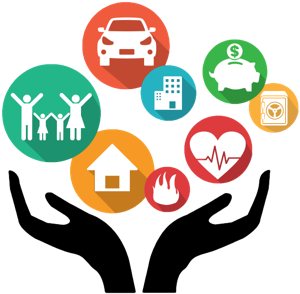
In a one-click shopping world with on-demand everything, the life insurance application process is antiquated. Customers provide extensive information to identify risk classification and eligibility, including scheduling medical exams, a process that takes an average of 30 days.

The result? People are turned off. That’s why only 40% of U.S. households own individual life insurance. Prudential wants to make it quicker and less labor intensive for new and existing customers to get a quote while maintaining privacy boundaries.

By developing a predictive model that accurately classifies risk using a more automated approach, you can greatly impact public perception of the industry.

The results will help Prudential better understand the predictive power of the data points in the existing assessment, enabling us to significantly streamline the process.

### Dataset Description
In this dataset, you are provided over a hundred variables describing attributes of life insurance applicants. The task is to predict the "Response" variable for each Id in the test set. "Response" is an ordinal measure of risk that has 8 levels.

Dataset Link: https://www.kaggle.com/c/prudential-life-insurance-assessment

## Download the Dataset

- Install required libraries
- Download data from Kaggle
- View dataset files
- Load training set with Pandas
- Load test set with Pandas

Dataset link: https://www.kaggle.com/c/prudential-life-insurance-assessment/overview

### Install Required Libraries

In [2]:
!pip install numpy pandas jovian opendatasets scikit-learn xgboost shap tune_sklearn skorch hyperopt torch torchvision --quiet

In [3]:
import jovian

In [4]:
# Execute this to save the notebook into jovian profile
jovian.commit(project="ml-course-project-final-prudential-life-insurance")

<IPython.core.display.Javascript object>

[jovian] Creating a new project "2021sc04667/ml-course-project-final-prudential-life-insurance"
[jovian] Committed successfully! https://jovian.com/2021sc04667/ml-course-project-final-prudential-life-insurance


'https://jovian.com/2021sc04667/ml-course-project-final-prudential-life-insurance'

# 0. Preliminaries

### > Set Configurations 

- Set the configurations for this notebook

In [5]:
config = {
    'data_name': 'prudential-life-insurance-assessment',
    'random_state': 2022
}

# 1. Data preprocessing

The data preprocessing works are divided into 8 steps here.

Some of these steps are mandatory and some are optional.

Optional steps are marked separately.

It is important to go through each step in order.
Be careful not to reverse the order.

## 1-1. Load Dataset

Load train-set and test-set on working environment


### Download Data from Kaggle

We'll use the opendatasets library: https://github.com/JovianML/opendatasets

In [6]:
import opendatasets as od

In [8]:
dataset_url = 'https://www.kaggle.com/c/prudential-life-insurance-assessment/overview'

In [9]:
%%time
od.download(dataset_url)

Skipping, found downloaded files in ".\prudential-life-insurance-assessment" (use force=True to force download)
CPU times: total: 0 ns
Wall time: 1.04 ms


In [10]:
data_dir = './prudential-life-insurance-assessment'

In [11]:
import numpy as np
import pandas as pd
import os

In [12]:
os.listdir(data_dir)

['sample_submission.csv.zip', 'test.csv.zip', 'train.csv.zip']

In [13]:
for root, dirs, files in os.walk(data_dir):
    for file in files:
        file_path = os.path.join(root, file)
        file_size = os.path.getsize(file_path)
        df = pd.read_csv(file_path)
        print(f"File path {file_path}: {round(file_size/(1024*1024),2)} MB, total rows: {df.shape[0]} and total columns: {df.shape[1]}")
        print(df.info())

File path ./prudential-life-insurance-assessment\sample_submission.csv.zip: 0.02 MB, total rows: 19765 and total columns: 2
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19765 entries, 0 to 19764
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   Id        19765 non-null  int64
 1   Response  19765 non-null  int64
dtypes: int64(2)
memory usage: 309.0 KB
None
File path ./prudential-life-insurance-assessment\test.csv.zip: 0.8 MB, total rows: 19765 and total columns: 127
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19765 entries, 0 to 19764
Columns: 127 entries, Id to Medical_Keyword_48
dtypes: float64(18), int64(108), object(1)
memory usage: 19.2+ MB
None
File path ./prudential-life-insurance-assessment\train.csv.zip: 2.42 MB, total rows: 59381 and total columns: 128
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59381 entries, 0 to 59380
Columns: 128 entries, Id to Response
dtypes: float64(18), int64(109), object(1)

**Observations:**

- This is a classic supervised machine learning problem
- Training data has 59381 rows
- Test set has 19765 rows
- The training set has 128 columns (Id to Response)
- The test set has 127 columns (Id to Medical_Keyword_48) except the target column (Response).
- The submission file should contain the `id` and `Response` for each test sample.

## **Reading Data**

In [15]:
#pd.read_csv(data_dir + '/train.csv.zip', index_col='Id')
train = pd.read_csv(data_dir + '/train.csv.zip'.format(config['data_name']))
test = pd.read_csv(data_dir + '/test.csv.zip'.format(config['data_name']))

> ### Concatenate the 'train' and 'test' data for preprocessing

Data preprocessing work should be applied equally for train-set and test-set.

In order to work at once, exclude the response variable 'Response' from 'train' and combine it with 'test'.

In [16]:
all_features = pd.concat((train.drop(['Id','Response'], axis=1), test.drop(['Id'], axis=1)), axis=0)

## 1-2. Missing Value Treatment

Missing (NA) values in Data must be treated properly before model training.

There are three main treatment methods:
1. Remove the variables which have NA values
2. Remove the rows (observations) which have NA values
3. Impute the NA values with other values

Which of the above methods is chosen is at the analyst's discretion.
It is important to choose the appropriate method for the situation.

### > Check missing values in each variable


<AxesSubplot:>

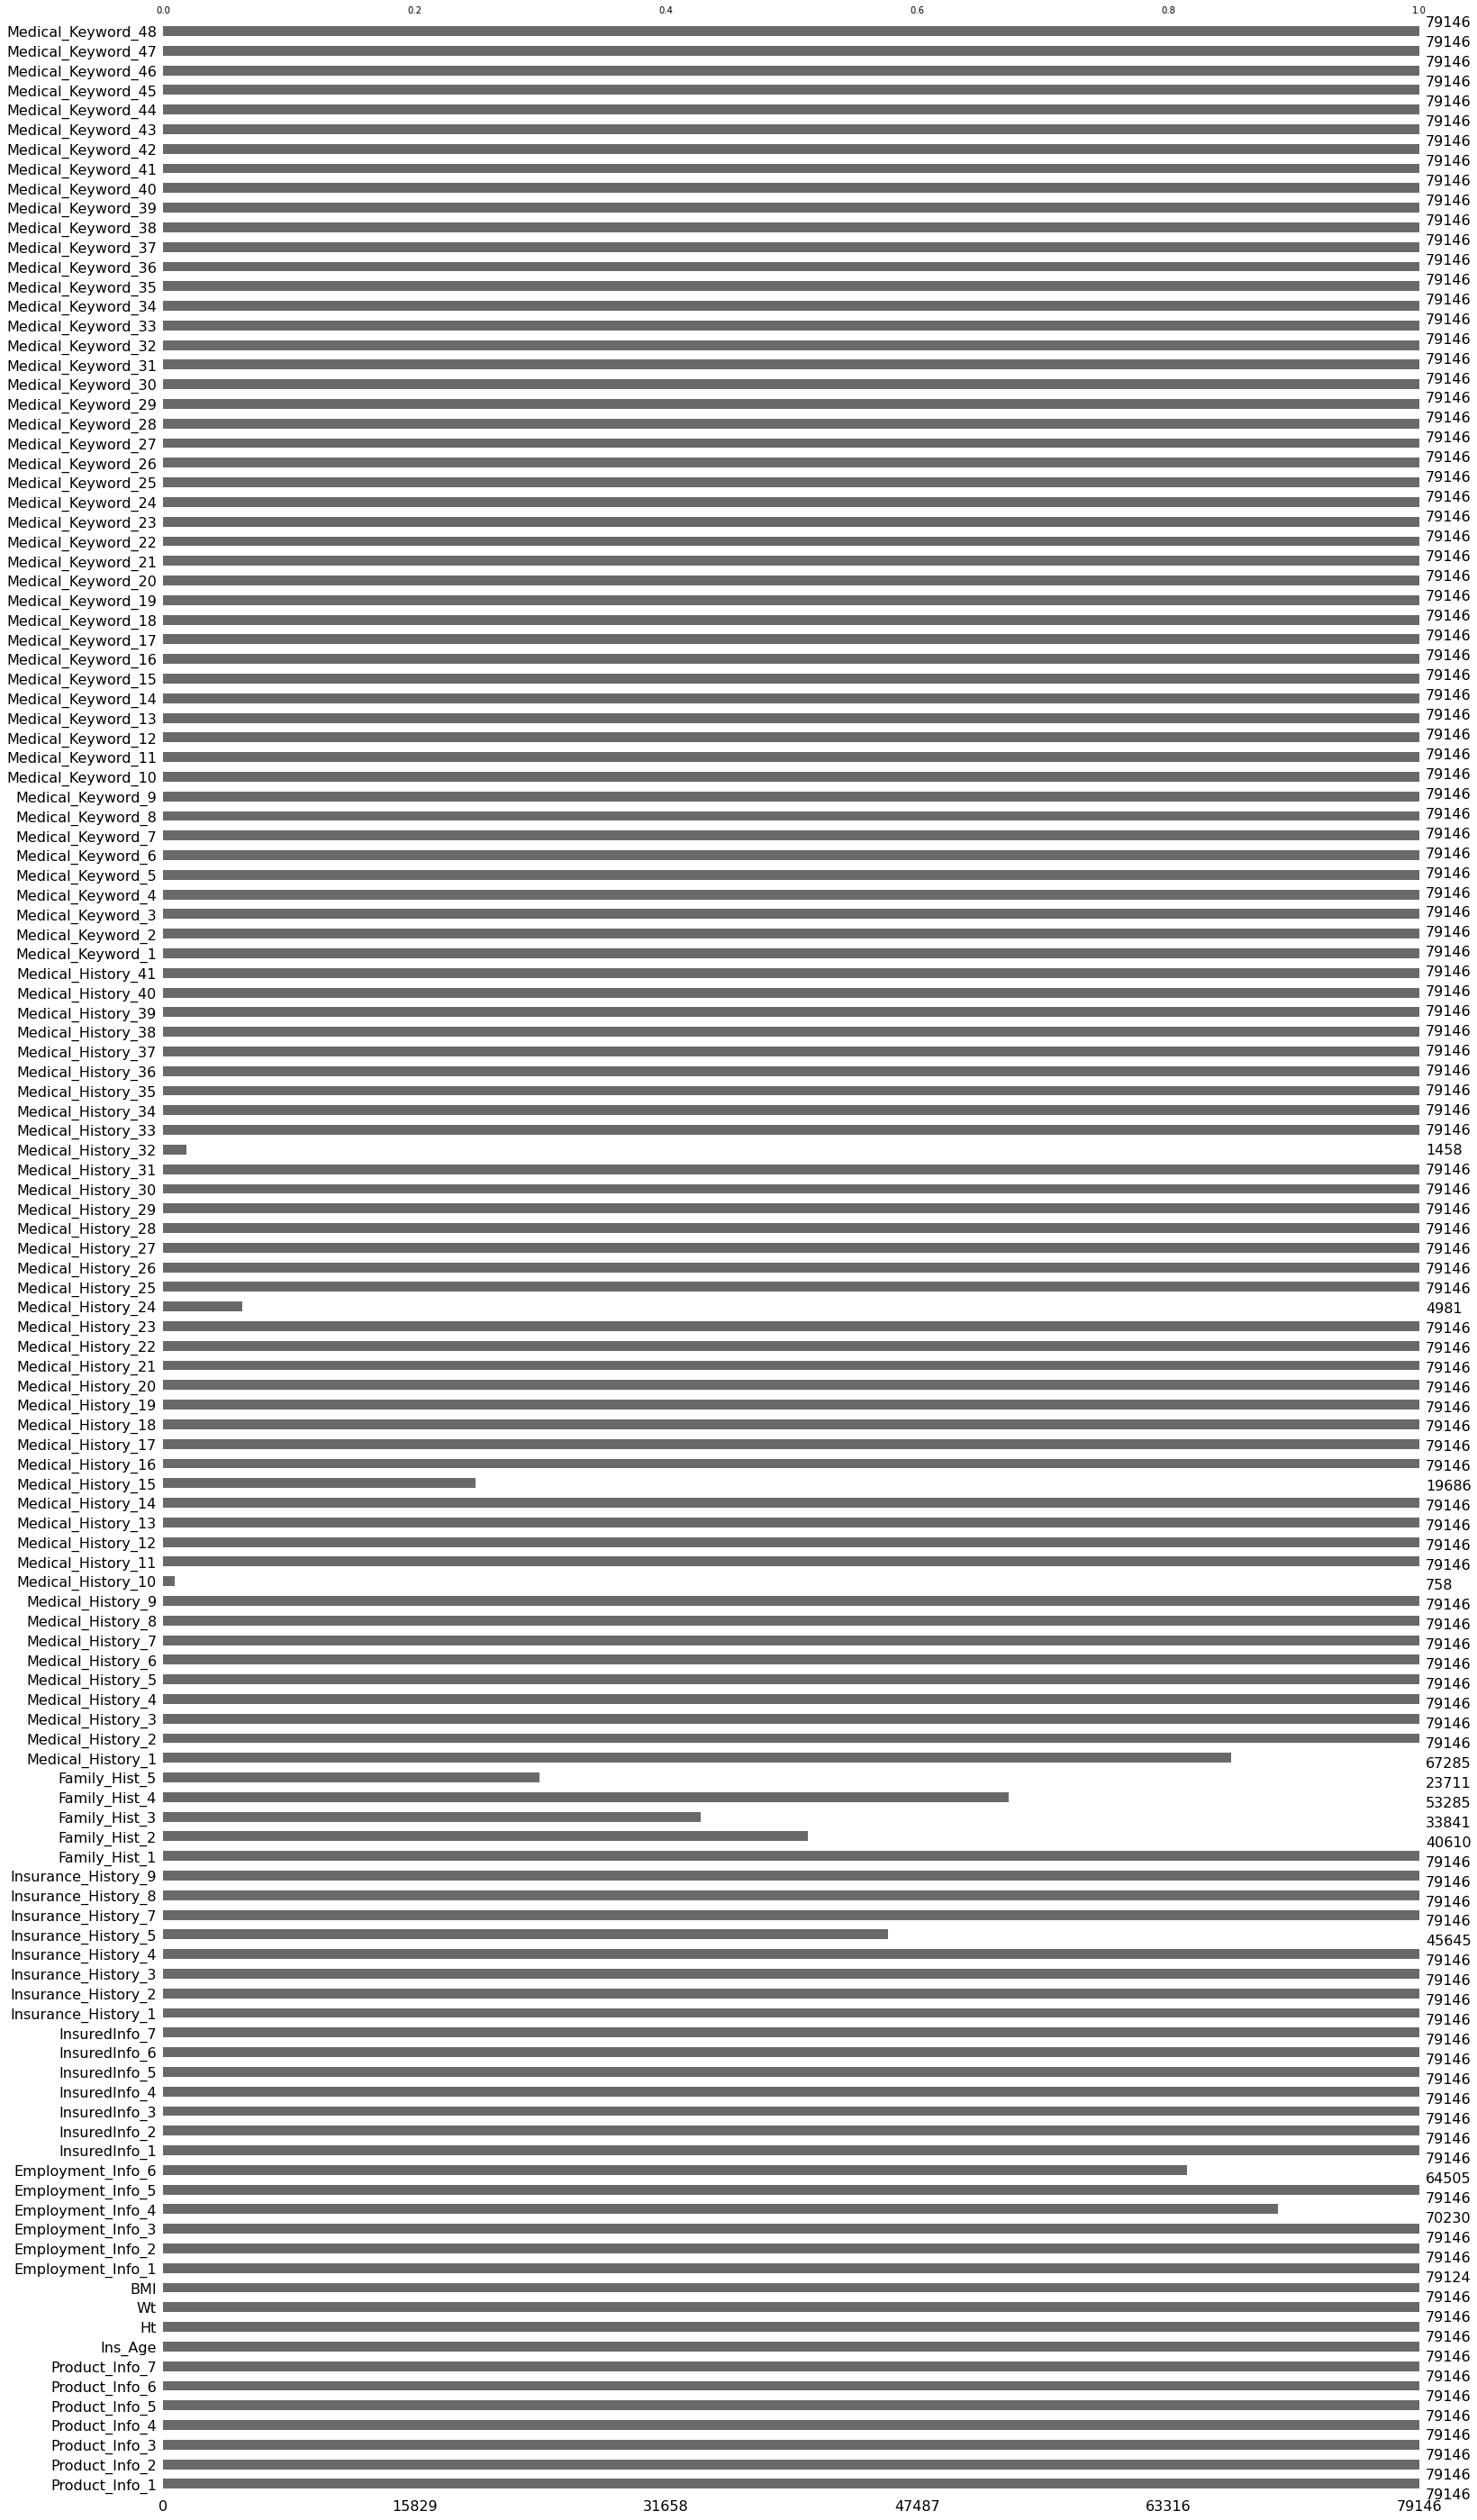

In [17]:
import missingno as msno
msno.bar(all_features)

### > Remove highly proportioned nan variables (nan proportion > 30%)

In [18]:
condition_col_idx = ((all_features.isnull().sum() / all_features.shape[0]) > 0.3).values

print(all_features.iloc[:,condition_col_idx].isnull().sum()/ all_features.shape[0])

all_features = all_features.iloc[:, ~condition_col_idx]

Insurance_History_5    0.423281
Family_Hist_2          0.486898
Family_Hist_3          0.572423
Family_Hist_4          0.326751
Family_Hist_5          0.700414
Medical_History_10     0.990423
Medical_History_15     0.751270
Medical_History_24     0.937066
Medical_History_32     0.981578
dtype: float64


### > Impute the NA values properly

There are 4 variables that have NA values left.

And these are all numeric (interger, float) variables

In [19]:
all_features.iloc[:,all_features.isnull().any().values].head()

Employment_Info_1  Employment_Info_4  Employment_Info_6  Medical_History_1
0              0.028                0.0                NaN                4.0
1              0.000                0.0             0.0018                5.0
2              0.030                0.0             0.0300               10.0
3              0.042                0.0             0.2000                0.0
4              0.027                0.0             0.0500                NaN

#### >> Replace NA by 'median value' of the variable grouped by another (relevant) categorical variable


The figures below show that the distribution of y-axis variable is different depending on the x-axis variable values.

(ANOVA test is used to determine whether the differences between groups are significant.)


In [20]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

by_var_list = ['Employment_Info_2', 'Employment_Info_3', 'Employment_Info_5']
target_list = ['Employment_Info_1', 'Employment_Info_4', 'Employment_Info_6']

anova_res_list = []
for target in target_list:
    for by_var in by_var_list:
        formula = target + '~' + by_var
        model = ols(formula, data=all_features).fit()
        anova_table = sm.stats.anova_lm(model, typ=2)
        anova_res_list.append([target, by_var, anova_table['F'][0]])

anova_res = pd.DataFrame(np.vstack((anova_res_list)), columns=['target', 'by_var', 'F-statistic'])    
anova_res['F-statistic'] = anova_res['F-statistic'].astype(np.float32)

import plotly.express as px
fig = px.bar(anova_res, x='target', y='F-statistic', color='by_var', width=800, height=400, barmode='group')
fig.show()

In [21]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

by_var_list = all_features.iloc[:,all_features.columns.str.startswith('Medical')].select_dtypes(exclude=np.float64).columns
target_list = ['Medical_History_1']

anova_res_list = []
for target in target_list:
    for by_var in by_var_list:
        formula = target + '~' + by_var
        model = ols(formula, data=all_features).fit()
        anova_table = sm.stats.anova_lm(model, typ=2)
        anova_res_list.append([target, by_var, anova_table['F'][0]])

anova_res = pd.DataFrame(np.vstack((anova_res_list)), columns=['target', 'by_var', 'F-statistic'])    
anova_res['F-statistic'] = anova_res['F-statistic'].astype(np.float32)

import plotly.express as px
fig = px.bar(anova_res, x='target', y='F-statistic', color='by_var', width=800, height=400, barmode='group')
fig.show()

In [22]:
method = 'median'

all_features.loc[:,'Employment_Info_1'] = all_features.loc[:,'Employment_Info_3'].fillna(all_features.groupby('Employment_Info_3')['Employment_Info_1'].transform(method))
all_features.loc[:,'Employment_Info_4'] = all_features.loc[:,'Employment_Info_3'].fillna(all_features.groupby('Employment_Info_5')['Employment_Info_4'].transform(method))
all_features.loc[:,'Employment_Info_6'] = all_features.loc[:,'Employment_Info_3'].fillna(all_features.groupby('Employment_Info_3')['Employment_Info_6'].transform(method))

all_features.loc[:,'Medical_History_1'] = all_features.loc[:,'Medical_History_23'].fillna(all_features.groupby('Medical_History_23')['Medical_History_1'].transform(method))

C:\Users\mcasi\AppData\Local\Temp\ipykernel_10444\2005875615.py:3: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\mcasi\AppData\Local\Temp\ipykernel_10444\2005875615.py:4: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

C:\Users\mcasi\AppData\Local\Temp\ipykernel_10444\2005875615.py:5: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newval

In [23]:
assert not all_features.isnull().sum().any()

## 1-3. Categorical variable consideration

### > 'Medical_Keyword_[1-48]' variables

'Medical_Keyword_[1-48]' variables have only {0, 1} values

In [24]:
var_idx = all_features.columns.str.startswith('Medical_Keyword')
np.unique(all_features.iloc[:,var_idx].values)

array([0, 1], dtype=int64)

But sum of values through axis=1 has values > 1.

So, we can think that these variables are set of one-hot encoded (dummified) variables,
NOT one-hot encoded on 'ONE' variable.

Thus we should change the data type from 'int64' to 'uint8' to prevent additional one-hot encoding

In [25]:
all_features.iloc[:,var_idx].sum(axis=1).value_counts()

0     31247
1     21430
2     12573
3      7046
4      3652
5      1793
6       796
7       374
8       132
9        67
10       24
11        5
12        3
16        2
14        1
13        1
dtype: int64

In [26]:
var_idx = all_features.columns.str.startswith('Medical_Keyword')
all_features.iloc[:,var_idx] = all_features.iloc[:,var_idx].astype(np.uint8)

C:\Users\mcasi\AppData\Local\Temp\ipykernel_10444\4237021422.py:2: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`



## 1-4. Dummify categorical variables

In the case of linear modeling without regularization, the first or last column should be dropped (to prevent linear dependency), but here, for the convenience of using the factorization model, one-hot encoding method is used that does not drop any columns.

In [27]:
data_set = pd.get_dummies(all_features, drop_first=False)

## 1-5. Scaling continuous variables

MinMaxScaling maps all variables from 0 to 1 in order to consider only relative information, not absolute magnitudes of the values.

Besides, it is known that scaling is often more stable in parameter optimization when training a model.

In [28]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data_set = scaler.fit_transform(data_set)

## 1-6. Split Train & Test set

In [29]:
n_train = train.shape[0]
X_train = data_set[:n_train].astype(np.float32)
X_test = data_set[n_train:].astype(np.float32)
y_train = train['Response'].values.astype(np.int64)

## 1-7. Outlier Detection on Training data (*optional*)

Detect and remove outlier observations that exist in the train-set.

- Methodology: [Isolation Forest](https://ieeexplore.ieee.org/abstract/document/4781136/?casa_token=V7U3M1UIykoAAAAA:kww9pojtMeJtXaBcNmw0eVlJaXEGGICi1ogmeHUFMpgJ2h_XCbSd2yBU5mRgd7zEJrXZ01z2)
  - How it works
    - Isolation Forest applies a decision tree that repeats splits based on the 'random criterion' for the given data unitl only one observation remains in every terminal node (this is defined as 'isolation').
    - Based on the number of splits used for isolation, 'normality' is defined. A smaller value means a higher degree of outlierness.
    - By applying this decision tree several times, the average of the measured 'normality' values ​​is derived as the final 'normality' value.
  - Assumptions
    - Outliers require relatively few splits to be isolated.
    - For normal data, the number of splits required to be isolated is relatively large.
  - Outlier determination
    - Determines whether it is an outlier or not based on the measured 'normality' value.
      - sklearn's IsolationForest package determines based on '0' 
      - I, personally, think it is better to set the discriminant criterion by considering the 'distribution' of the 'normality' values.
      - The details of the method is given below.

In [30]:
from sklearn.ensemble import IsolationForest
clf = IsolationForest(
    n_estimators=100,
    max_samples='auto',
    n_jobs=-1,
    random_state=config['random_state'])

clf.fit(X_train)
normality_df = pd.DataFrame(clf.decision_function(X_train), columns=['normality'])

- The dicriminant value 
  - The discriminant value (threshold) is defined by calculating the 1st quartile ($q_1$) and 3rd quartile ($q_3$) on the distribution of the measured normality values.
    - with $k=1.5$

$$threshold = q_1 - k*(q_3 - q_1)$$


- Motivation
  - This discriminant method is adapted from Tukey's boxplot idea.
In the distribution of any continuous variable, Tukey designates observations smaller than that value or larger than q_3 + k*(q_3 - q_1) as outliers.

- How we do 
  - Our methodology does not apply the above method to a specific variable, but applies the method to the obtained normality.

  - That is, it is based on the assumption that an outlier will be far left from the other observations in the measured normality distribution.

In [31]:
def outlier_threshold(normality, k=1.5):
    q1 = np.quantile(normality, 0.25)
    q3 = np.quantile(normality, 0.75) 
    threshold = q1 - k*(q3-q1)
    return threshold

threshold = outlier_threshold(normality_df['normality'].values, k=1.5)

import plotly.express as px
fig = px.histogram(normality_df, x='normality', width=400, height=400)
fig.add_vline(x=threshold, line_width=3, line_dash="dash", line_color="red")
fig.show()

In [32]:
import plotly.express as px
px.box(normality_df, x='normality', orientation='h', width=400, height=400)

In [33]:
X_train = X_train[normality_df['normality'].values>=threshold]
y_train = y_train[normality_df['normality'].values>=threshold]

print('{} out of {} observations are removed from train_set'.format(train.shape[0] - X_train.shape[0], train.shape[0]))

1335 out of 59381 observations are removed from train_set


## 1-8. Output variable transformation

In [34]:
print('Before transformation:', np.unique(y_train))

y_train_trans = y_train - 1

print('After transformation:', np.unique(y_train_trans))

Before transformation: [1 2 3 4 5 6 7 8]
After transformation: [0 1 2 3 4 5 6 7]



# 2. Model Selection


## > Modeling Strategy
Our goal is to build a model that predicts the type of risk in terms of life insurance for individuals given some informations. The formula can be expressed as:

$\hat{y} = \underset{k \in \{1,\cdots,K\}}{\operatorname{argmax}}f_{k}(x)$

where,
  - $y \in \{1,\cdots,K\} $: labels 
    - $ 1 < \cdots < K$
  - $x$: an input observation
  - $f_{k}(x)$: a function of $x$ that outputs predicted value for each $k$

This can be formulated as a "**ordinal** classification" problem whose output variable has a ordinal characteristic.


- Problem 
  - Standard classification models can not consider the ordinal relationship of output variable

- Solution 
  - According to [A Simple Approach to Ordinal Classification](https://www.cs.waikato.ac.nz/~eibe/pubs/ordinal_tech_report.pdf), by applying some simple methods, we can formulate the ordinal classification while using standard (binary) classification methods.
  > We can take advantage of the ordered class value by transforming a k-class ordinal regression problem to a k-1 binary classification problem, we convert an ordinal attribute A* with ordinal value V1, V2, V3, … Vk into k-1 binary attributes, one for each of the original attribute’s first k − 1 values. The ith binary attribute represents the test A* > Vi

  - How it works
    1. Convert an ordinal output variable Y into k-1 binary attributes ($Y_{1}, \cdots Y_{K-1}$). The i-th binary attributes $Y_{i} \in \\{0, 1\\}$ represents $Y > i$
    2. Estimate the probabilities $Pr(Y_{1} = 1), \cdots, Pr(Y_{K-1}=1)$ by training each model on data which are same as $Pr(Y > 1), \cdots, Pr(Y > K-1)$
    3. Get the probabilities $Pr(Y=k)$ by using estimated $Pr(Y > 1), \cdots, Pr(Y > K-1)$. i.e.,
      - $Pr(Y=1) = 1 - Pr(Y>1) $
      - $Pr(Y=i) = Pr(Y>i-1) - Pr(Y>i)$
      - $Pr(Y=K) = Pr(Y>K-1)$

Below figure shows the overall procedure, when $Y \in \{1, 2, 3, 4\}$

<center><img src='https://drive.google.com/uc?export=view&id=1ImlHhVUuBXAfHwEBfg0RS6NXXkDNJk3H' width = 1000></center>


## > Model Selection method

To estimate the probabilities for each binary classification model, we uses the following models.
- Logistic regression
- Random forest
- Xgboost
- Multi-layer perceptron

However, we have to "choose" one final methodology to make predictions on the test set.
To do this, a “fair evaluation” of the models is essential. "Fair evaluation" must satisfy the following two conditions.

1. Select optimal hyperparameters for each model
  - If hyperparameter search is not performed, the difference in model performance may occur due to incorrect hyperparameter values.
2. same evaluation method
  - If the same evaluation method is not applied, comparison between models itself is impossible.

When comparing models through an evaluation method that satisfies the above two conditions,
Only then can the final model be selected.




### > Define a scoring function for hyper parameter tuning


In [35]:
from sklearn.metrics import make_scorer
from sklearn.metrics import cohen_kappa_score

def weighted_kappa(y_true, y_pred):
    try:
        score = cohen_kappa_score(y_true, y_pred, weights='quadratic')
    except:
        score = np.nan
    return score

target_metric = make_scorer(weighted_kappa, greater_is_better=True)

## 2-1. Define a Ordinal Classificatier class

This class enables the ordinal classification formulation by using the standard binary classification models


In [36]:
from sklearn.base import BaseEstimator
from sklearn.base import clone
from sklearn.metrics import accuracy_score
class OrdinalClassifier(BaseEstimator):

    def __init__(self, clf):
        self.clf = clf
        self.clfs = {}

    def fit(self, X, y):
        self.unique_class = np.sort(np.unique(y))
        if self.unique_class.shape[0] > 2:
            for i in range(self.unique_class.shape[0]-1):
                
                binary_y = (y > self.unique_class[i]).astype(np.uint8)
                clf = clone(self.clf)
                try:
                    clf.module
                except: 
                    clf.fit(X, binary_y)
                else: 
                    binary_y_reshape = binary_y.astype('float32').reshape(-1,1)
                    clf.fit(X, binary_y_reshape)
                self.clfs[i] = clf

    def predict_proba(self, X):
        clfs_predict = {k: self.clfs[k].predict_proba(X) for k in self.clfs}
        predicted = []
        for i, y in enumerate(self.unique_class):
            if i == 0:
                predicted.append(1 - clfs_predict[i][:,1])
            elif i in clfs_predict:
                predicted.append(clfs_predict[i-1][:,1] - clfs_predict[i][:,1])
            else:
                
                predicted.append(clfs_predict[i-1][:,1])
        try:
            self.clf.module
        except: 
            pred_proba = np.vstack(predicted).T      
        else: 
            pred_proba = np.hstack((predicted))
        
        return pred_proba

    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)

    def score(self, X, y, sample_weight=None):
        _, indexed_y = np.unique(y, return_inverse=True)
        return accuracy_score(indexed_y, self.predict(X), sample_weight=sample_weight)


## 2-2. Hyper parameter tuning by using Tune_SKlearn (Ray Tune)

- Package: tune_sklearn
  - This package makes it easy to apply [Ray Tune](https://docs.ray.io/en/latest/tune/index.html) to sklearn models.
  - Ray Tune is a python package that provides various hyperparameter tuning algorithms (HyperOpt, BayesianOptimization, ...).
- Tuning procedure
  - Define an appropriate search space for each model's hyperparameters.
  - 5-fold CV (Cross Validation) is performed for each specific hyper-parameter value combination of the search space by using the hyper-parameter tuning algorithm (HyperOpt)
    - Training: Training by using Scikit-Learn and Skorch packages
    - Validation: Evaluate the model using an appropriate evaluation metric
  - The hyperparameter with the highest average score of the CV result is designated as the optimal hyperparameter of the model.
    - Save this CV result and use for model comparison



### > Make a dataframe for containing CV results

In [37]:
model_list = []
for name in ['linear', 'rf', 'xgb', 'mlp']:
    model_list.append(np.full(5, name))
best_cv_df = pd.DataFrame({'model': np.hstack((model_list)), 'accuracy':None, 'kappa':None, 'best_hyper_param': None})

### Logistic regression

In [38]:
from tune_sklearn import TuneSearchCV
from sklearn.linear_model import SGDClassifier

# Define a search space
parameters = {
    'clf__alpha': list(np.geomspace(1e-5, 1e-2, 4)),
    'clf__max_iter': [1000],
    'clf__tol': [1e-4, 1e-3, 1e-2],
    'clf__loss': ['log'],
    'clf__penalty': ['l2'],
    'clf__random_state': [config['random_state']],
}

# Define a Ordinal classifier
clf = SGDClassifier()
ordinal_clf = OrdinalClassifier(clf)

# Specify the hyper parameter tuning algorithm
tune_search = TuneSearchCV(
    ordinal_clf,
    parameters,
    search_optimization='hyperopt',
    n_trials=6,
    n_jobs=-1,
    scoring={'accuracy':'accuracy', 'kappa':target_metric},
    cv=5,
    refit='kappa',
    verbose=1,
    random_state=config['random_state']
    )

# Run hyper parameter tuning
X = X_train
y = y_train_trans
tune_search.fit(X, y)

# Save the tuning results 
model_name = 'linear'

## Save the optimal hyper parmater values
best_cv_df.loc[best_cv_df['model']==model_name, 'best_hyper_param'] = str(tune_search.best_params_)

## Save the CV results
cv_df = pd.DataFrame(tune_search.cv_results_)
cv_values = cv_df.loc[tune_search.best_index_, cv_df.columns.str.startswith('split')].values
best_cv_df.loc[best_cv_df['model']==model_name, 'accuracy'] = cv_values[:5]
best_cv_df.loc[best_cv_df['model']==model_name, 'kappa'] = cv_values[5:]

# Visualize the tuning results with parallel coordinate plot
tune_result_df = pd.concat([pd.DataFrame(tune_search.cv_results_['params']), cv_df.loc[:,cv_df.columns.str.startswith('mean')] ], axis=1)
import plotly.express as px
fig = px.parallel_coordinates(tune_result_df, color='mean_test_kappa')
fig.show()

(_Trainable pid=14092) C:\Users\mcasi\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
(_Trainable pid=14092)   warnings.warn(
(_Trainable pid=14092) C:\Users\mcasi\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
(_Trainable pid=14092)   warnings.warn(
(_Trainable pid=14092) C:\Users\mcasi\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
(_Trainable pid=14092)   warnings.warn(
(_Trainable pid=14092) C:\Users\mcasi\AppData\Roaming\Python\Python39\site-package

(_Trainable pid=13396) C:\Users\mcasi\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent. [repeated 5x across cluster]
(_Trainable pid=13396)   warnings.warn( [repeated 5x across cluster]
(_Trainable pid=13396) C:\Users\mcasi\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent. [repeated 5x across cluster]
(_Trainable pid=13396)   warnings.warn( [repeated 5x across cluster]
(_Trainable pid=13396) C:\Users\mcasi\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent. [repea

C:\Users\mcasi\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_stochastic_gradient.py:163: FutureWarning:

The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.

C:\Users\mcasi\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_stochastic_gradient.py:163: FutureWarning:

The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.

C:\Users\mcasi\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_stochastic_gradient.py:163: FutureWarning:

The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.

C:\Users\mcasi\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_stochastic_gradient.py:163: FutureWarning:

The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.

C:\Users\mcasi\AppDa

### Random forest

In [39]:
from tune_sklearn import TuneSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define a search space
parameters = {
    'clf__n_estimators': [50, 100],
    'clf__criterion': ['gini', 'entropy'],
    'clf__max_depth': [20, 25, 30],
    'clf__max_features': ['auto'],
    'clf__random_state': [config['random_state']]
}

# Define a Ordinal classifier
clf = RandomForestClassifier()
ordinal_clf = OrdinalClassifier(clf)

# Specify the hyper parameter tuning algorithm
tune_search = TuneSearchCV(
    ordinal_clf,
    parameters,
    search_optimization='hyperopt',
    n_trials=4,
    n_jobs=-1,
    scoring={'accuracy':'accuracy', 'kappa':target_metric},
    cv=5,
    refit='kappa',
    verbose=1,
    random_state=config['random_state']
    )

# Run hyper parameter tuning
X = X_train
y = y_train_trans
tune_search.fit(X, y)

# Save the tuning results 
model_name = 'rf'

## Save the optimal hyper parmater values
best_cv_df.loc[best_cv_df['model']==model_name, 'best_hyper_param'] = str(tune_search.best_params_)

## Save the CV results
cv_df = pd.DataFrame(tune_search.cv_results_)
cv_values = cv_df.loc[tune_search.best_index_, cv_df.columns.str.startswith('split')].values
best_cv_df.loc[best_cv_df['model']==model_name, 'accuracy'] = cv_values[:5]
best_cv_df.loc[best_cv_df['model']==model_name, 'kappa'] = cv_values[5:]

# Visualize the tuning results with parallel coordinate plot
tune_result_df = pd.concat([pd.get_dummies(pd.DataFrame(tune_search.cv_results_['params']), drop_first=False), 
                            cv_df.loc[:,cv_df.columns.str.startswith('mean')] ], axis=1)
tune_result_df = tune_result_df.astype({'clf__criterion_entropy':'int64', 'clf__criterion_gini':'int64'})
import plotly.express as px
px.parallel_coordinates(tune_result_df, color='mean_test_kappa')

(_Trainable pid=9924) C:\Users\mcasi\AppData\Roaming\Python\Python39\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
(_Trainable pid=9924)   warn(
(_Trainable pid=3008) C:\Users\mcasi\AppData\Roaming\Python\Python39\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers. [repeated 4x across cluster]
(_Trainable pid=3008)   warn( [repeated 4x across cluster]
(_Trainable pid=3008) C:\Users\mcasi\AppData\Roaming\Python\Python39\site-packages\sklearn\ensemble\_forest.py:4

(_Trainable pid=13528) C:\Users\mcasi\AppData\Roaming\Python\Python39\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers. [repeated 3x across cluster]
(_Trainable pid=13528)   warn( [repeated 3x across cluster]
(_Trainable pid=3008) C:\Users\mcasi\AppData\Roaming\Python\Python39\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers. [repeated 4x across cluster]
(_Trainable pid=3008)   warn( [repeated 4x across cluster]
(_Trainable pid=3008) C:\Users\mcasi\AppData\Roaming

(_Trainable pid=13528) C:\Users\mcasi\AppData\Roaming\Python\Python39\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers. [repeated 4x across cluster]
(_Trainable pid=13528)   warn( [repeated 4x across cluster]
(_Trainable pid=3008) C:\Users\mcasi\AppData\Roaming\Python\Python39\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers. [repeated 3x across cluster]
(_Trainable pid=3008)   warn( [repeated 3x across cluster]
(_Trainable pid=3008) C:\Users\mcasi\AppData\Roaming

(_Trainable pid=9924) C:\Users\mcasi\AppData\Roaming\Python\Python39\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
(_Trainable pid=9924)   warn(
(_Trainable pid=9924) C:\Users\mcasi\AppData\Roaming\Python\Python39\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
(_Trainable pid=9924)   warn(
(_Trainable pid=9924) C:\Users\mcasi\AppData\Roaming\Python\Python39\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecat

### XGBoost

In [40]:
from tune_sklearn import TuneSearchCV
from xgboost import XGBClassifier

# Define a search space
parameters = {
    'clf__n_estimators': [10, 50],
    'clf__learning_rate': list(np.geomspace(1e-2, 1, 3)),
    'clf__min_child_weight': [5, 10, 15],
    'clf__gamma': [0.5, 2],
    'clf__subsample': [0.6, 1.0],
    'clf__colsample_bytree': [0.6, 1.0],
    'clf__max_depth': [5, 10, 15],
    'clf__lambda': [1],
    'clf__objective': ['binary:logistic'],
    'clf__random_state': [config['random_state']]
}

# Define a Ordinal classifier
clf = XGBClassifier()
ordinal_clf = OrdinalClassifier(clf)

# Specify the hyper parameter tuning algorithm
tune_search = TuneSearchCV(
    ordinal_clf,
    parameters,
    search_optimization='hyperopt',
    n_trials=4,
    n_jobs=-1,
    scoring={'accuracy':'accuracy', 'kappa':target_metric},
    cv=5,
    refit='kappa',
    verbose=1,
    random_state=config['random_state']
    )

# Run hyper parameter tuning
X = X_train
y = y_train_trans
tune_search.fit(X, y)

# Save the tuning results 
model_name = 'xgb'

## Save the optimal hyper parmater values
best_cv_df.loc[best_cv_df['model']==model_name, 'best_hyper_param'] = str(tune_search.best_params_)

## Save the CV results
cv_df = pd.DataFrame(tune_search.cv_results_)
cv_values = cv_df.loc[tune_search.best_index_, cv_df.columns.str.startswith('split')].values
best_cv_df.loc[best_cv_df['model']==model_name, 'accuracy'] = cv_values[:5]
best_cv_df.loc[best_cv_df['model']==model_name, 'kappa'] = cv_values[5:]

# Visualize the tuning results with parallel coordinate plot
tune_result_df = pd.concat([pd.DataFrame(tune_search.cv_results_['params']), cv_df.loc[:,cv_df.columns.str.startswith('mean')] ], axis=1)
import plotly.express as px
fig = px.parallel_coordinates(tune_result_df, color='mean_test_kappa')
fig.show()

2023-04-29 19:33:50,546	INFO tune.py:945 -- Total run time: 747.09 seconds (747.07 seconds for the tuning loop).
C:\ProgramData\Anaconda3\lib\site-packages\plotly\express\_core.py:279: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



### Multi-layer perceptron

In [41]:
import torch
from torch import nn
from skorch import NeuralNetClassifier
from skorch.callbacks import EarlyStopping
from skorch.callbacks import EpochScoring
from skorch.callbacks import Checkpoint
from tune_sklearn import TuneSearchCV

# Define a model structure
class MLP(nn.Module):
    def __init__(self, num_inputs=X_train.shape[1], num_outputs=1, layer1=512, layer2=256, dropout1=0, dropout2=0):
        super(MLP, self).__init__()

        self.linear_relu_stack = nn.Sequential(
            nn.Linear(num_inputs, layer1),
            nn.LeakyReLU(),
            nn.Dropout(dropout1),
            nn.Linear(layer1, layer2),
            nn.LeakyReLU(),
            nn.Dropout(dropout2),
            nn.Linear(layer2, num_outputs)
            )
    def forward(self, x):
        x = self.linear_relu_stack(x)
        return x  

def try_gpu(i=0): 
    return f'cuda:{i}' if torch.cuda.device_count() >= i + 1 else 'cpu'

# Set model configurations
mlp = NeuralNetClassifier(
    MLP(num_inputs=X_train.shape[1], num_outputs=1),
    criterion=nn.BCEWithLogitsLoss(),
    optimizer=torch.optim.Adam,
    device=try_gpu(),
    verbose=0,
    callbacks=[EarlyStopping(monitor='valid_loss', patience=5,
                             threshold=1e-3, lower_is_better=False)]
                          )
# Define a search space
parameters = {
    'clf__lr': list(np.geomspace(1e-4, 1e-1, 4)),
    'clf__module__layer1': [128, 256, 512],
    'clf__module__layer2': [128, 256, 512],
    'clf__module__dropout1': [0, 0.1],
    'clf__module__dropout2': [0, 0.1],
    'clf__batch_size': [128, 256],
    'clf__optimizer__weight_decay': list(np.geomspace(1e-5, 1e-1, 5)),
    'clf__max_epochs': [2000],
    'clf__iterator_train__shuffle': [True],
    'clf__callbacks__EarlyStopping__threshold': [1e-4, 1e-3]
    }

def use_gpu(device):
    return True if not device == 'cpu' else False 

# Define a Ordinal classifier
clf = mlp
ordinal_clf = OrdinalClassifier(clf)

# Specify the hyper parameter tuning algorithm
tune_search = TuneSearchCV(
    ordinal_clf,
    parameters,
    search_optimization='hyperopt',
    n_trials=10,
    n_jobs=-1,
    scoring={'accuracy':'accuracy', 'kappa':target_metric},
    cv=5,
    refit='kappa',
    verbose=1,
    random_state=config['random_state']
    )

# Run hyper parameter tuning
X = X_train
y = y_train_trans
tune_search.fit(X, y)

# Save the tuning results 
model_name = 'mlp'

## Save the optimal hyper parmater values
best_cv_df.loc[best_cv_df['model']==model_name, 'best_hyper_param'] = str(tune_search.best_params_)

## Save the CV results
cv_df = pd.DataFrame(tune_search.cv_results_)
cv_values = cv_df.loc[tune_search.best_index_, cv_df.columns.str.startswith('split')].values
best_cv_df.loc[best_cv_df['model']==model_name, 'accuracy'] = cv_values[:5]
best_cv_df.loc[best_cv_df['model']==model_name, 'kappa'] = cv_values[5:]

# Visualize the tuning results with parallel coordinate plot
tune_result_df = pd.concat([pd.DataFrame(tune_search.cv_results_['params']), cv_df.loc[:,cv_df.columns.str.startswith('mean')] ], axis=1)
tune_result_df.rename({
    'clf__callbacks__EarlyStopping__threshold':'Earlystoping_threshold',
    'clf__optimizer__weight_decay': 'weight_decay'
    }, axis=1, inplace=True)

import plotly.express as px
px.parallel_coordinates(tune_result_df, color='mean_test_kappa')

2023-04-29 20:13:36,919	INFO tune.py:945 -- Total run time: 2343.68 seconds (2343.63 seconds for the tuning loop).
C:\ProgramData\Anaconda3\lib\site-packages\plotly\express\_core.py:279: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



### > Save CV results

## 2-3. Model Comparison based on CV results

Compare the CV results (measured using the optimal hyper parameter values).

The figure below shows that 

xgb > linear > mlp > rf




In [42]:
fig = px.box(best_cv_df, x='model', y='kappa', color='model', width=800)
fig.show()

## 2-4. Model Combination

Although it is possible to select a final model based on the above results, it has been observed that in many cases the combination of predicted values ​​from multiple models leads to improve prediction performance. ([Can multi-model combination really enhance the prediction skill of probabilistic ensemble forecasts?](https://rmets.onlinelibrary.wiley.com/doi/abs/10.1002/qj.210?casa_token=OwyF2RbEywAAAAAA:gahpwGRdOWzLXyafYQQt_voHOF8MedTBLd1SBv4vkdT3ZTLVoKZQj3zl-KbrhSkX5x8CndeCxwBoL_-S))

For classification problems, the final probabilities are derived by combining the predicted 'probabilities' for each class in a 'proper way'.

This notebook uses following two model combination methods.

1. Simple Average
2. Stacked Generalization (Stacking)


Model comparison needs to be done with single models (e.g., rf, xgb,...).
So model performance are measured by applying the same CV method as above.

Based on the CV results, we select (linear, xgb, mlp) as the base estimators for model combination.

### > Simple Average

The simple average method derives the final probability value by 'averaging' the predicted probability values ​​for each class of multiple models.

The top 3 models (linear, xgb, mlp) of the above CV results are selected as base estimators used for the combination of predicted values.

For example,
- Base Estimations
  - $P_{linear}(Y=1|X=x)$ = 0.80
  - $P_{xgb}(Y=1|X=x)$ = 0.80
  - $P_{mlp}(Y=1|X=x)$ = 0.85
- Final Estimation
  - $P_{average}(Y=1|X=x)$  = 0.817 (= 0.80 + 0.80 + 0.85 / 3)


In [43]:
from sklearn.model_selection import KFold
from tqdm import notebook
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.metrics import roc_auc_score

def CV_ensemble(ensemble_name, ensemble_func, estimators, X_train, y_train, n_folds=5, shuffle=True, random_state=2022):
    kf = KFold(n_splits=5, random_state=random_state, shuffle=True)

    res_list = []
    for train_idx, valid_idx in notebook.tqdm(kf.split(X_train), total=kf.get_n_splits(), desc='Eval_CV'):
        X_train_train, X_valid = X_train[train_idx], X_train[valid_idx]
        y_train_train, y_valid = y_train[train_idx], y_train[valid_idx]

    ensemble_pred_proba = ensemble_func(estimators, X_train_train, y_train_train, X_valid)
    accuracy = accuracy_score(y_valid, ensemble_pred_proba.argmax(axis=1))
    kappa = weighted_kappa(y_valid, ensemble_pred_proba.argmax(axis=1))

    res_list.append([ensemble_name, accuracy, kappa])
    res_df = pd.DataFrame(np.vstack((res_list)))
    res_df.columns = ['model', 'accuracy', 'kappa']
    return res_df

def ensemble_average(estimators, X_train, y_train, X_test):
    preds = []
    num_estimators = len(estimators)
    num_class = len(np.unique(y_train))
    for iter in range(num_estimators):
        estimators[iter].fit(X_train, y_train)
        preds.append(estimators[iter].predict_proba(X_test))
  
    preds_stack = np.hstack((preds))
    preds_mean = []
    for iter in range(num_class):
        col_idx = np.arange(iter, num_estimators * num_class, num_class)
        preds_mean.append(np.mean(preds_stack[:,col_idx], axis=1))

    pred_fin = np.vstack((preds_mean)).transpose()
    return pred_fin

In [44]:
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

linear_ordinal = OrdinalClassifier(SGDClassifier()).set_params(**eval(best_cv_df.loc[best_cv_df['model']=='linear', 'best_hyper_param'].values[0]))
rf_ordinal = OrdinalClassifier(RandomForestClassifier()).set_params(**eval(best_cv_df.loc[best_cv_df['model']=='rf', 'best_hyper_param'].values[0]))
xgb_ordinal = OrdinalClassifier(XGBClassifier()).set_params(**eval(best_cv_df.loc[best_cv_df['model']=='xgb', 'best_hyper_param'].values[0]))
mlp_ordinal = OrdinalClassifier(mlp).set_params(**eval(best_cv_df.loc[best_cv_df['model']=='mlp', 'best_hyper_param'].values[0]))

estimators = [linear_ordinal, xgb_ordinal, mlp_ordinal]
estimators_name = 'linear_xgb_mlp'
ensemble_name = 'average' + '_' + estimators_name

X = X_train
y = y_train_trans

res_df = CV_ensemble(ensemble_name, ensemble_average, estimators, X, y, n_folds=5, shuffle=True, random_state=config['random_state'])
best_cv_df = best_cv_df.append(res_df).reset_index(drop=True)

Eval_CV:   0%|          | 0/5 [00:00<?, ?it/s]

C:\Users\mcasi\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_stochastic_gradient.py:163: FutureWarning:

The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.

C:\Users\mcasi\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_stochastic_gradient.py:163: FutureWarning:

The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.

C:\Users\mcasi\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_stochastic_gradient.py:163: FutureWarning:

The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.

C:\Users\mcasi\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_stochastic_gradient.py:163: FutureWarning:

The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.

C:\Users\mcasi\AppDa

In [45]:
fig = px.box(best_cv_df, x='model', y='kappa', color='model', width=800)
fig.show()

### > Stacked generalization (Stacking)

In the [Stacked generalization](https://www.jair.org/index.php/jair/article/view/10228), the predicted probabilities of base estimators are treated as the 'input data', and y (Cover_Type) of each row is treated as the 'output variable'. 
The 'Meta Learner' is learned with these data and the predicted probablities of this model are derived as the final prediction probabilities.

- The 'Meta Learner' can be optained among any of the classification models. However, this notebook uses a ridge model (logistic regression with ridge penalty) to prevent overfitting.

- As input data for 'Meta Learner', prediction probabilities for validation data in cv of base estimators are obtained.

- Trained meta-learner predicts the final predicted probabilities for the test-set by using the predicted probabilites of baes estimators for the test-set as input data.

The total process, in order, is as follows:
1. (Base estimators) Run CV on Train-set
2. (Meta Learner) Train on CV predictions (predicted probabilities on validation data of CV) with corresponding y values
3. (Base estimators) Train on Train-set
4. (Base estimators) Predict on Test-set
5. (Meta Learner) Predict on predictions on Test-set

<img align='top' src='https://drive.google.com/uc?export=view&id=1uDxSIIFt8rUJkuIwRYU4lALvOPqlXPG5' width='600' height='400'>


For example,
- Assume that 
  - $Y \in \{0, 1, 2\}$
- Base Estimatiors
  - rf
    - $P_{rf}(Y=0|X=x)$ = 0.75
    - $P_{rf}(Y=1|X=x)$ = 0.10
    - $P_{rf}(Y=2|X=x)$ = 0.15
  - xgb
    - $P_{xgb}(Y=0|X=x)$ = 0.80
    - $P_{xgb}(Y=1|X=x)$ = 0.10
    - $P_{xgb}(Y=2|X=x)$ = 0.10
- Meta Learner (logistic regression with ridge (l2) penalty)
  - when Y=0:
    - intercept = 0.1
    - coefficient = [0.8, 0.1, -0.1, 0.9, 0.2, -0.05]
  - predicted probabilities
    - $P_{stack}(Y=0|X=x)$ = 0.8069 = sigmoid(0.1 + 0.8*0.75 + 0.1*0.1 -0.1*0.15 + 0.9*0.8 + 0.2*0.1 - 0.05*0.1)$


**Warnings**:

- the set of predicted probabilities $[P_{rf}(Y=1|X=x), \cdots, P_{xgb}(Y=2|X=x)]$ is a **linearly dependent ** matrix.
- Thus, as a final estimator, linear model with penalty or not a linear model is recommended.
- If you want to apply plain linear model with no penalty, please remove the first or last class probabilities of each base estimators (e.g., remove $P_{rf}(Y=2|X=x)$ and $P_{xgb}(Y=2|X=x)$)

In [46]:
from sklearn.model_selection import KFold
from tqdm import notebook


def stack_clf(estimators, X_train, y_train, X_test, n_folds=5, shuffle=True, random_state=2022):
    final_estimator = estimators[-1]
    num_estimators = len(estimators)-1

    kf = KFold(n_splits=n_folds, random_state=random_state, shuffle=shuffle)
    preds = []
    y_valid_list = []
    # Get CV predictions
    for train_idx, valid_idx in notebook.tqdm(kf.split(X_train), total=kf.get_n_splits(), desc='Stack_CV'):
        X_train_train, X_valid = X_train[train_idx], X_train[valid_idx]
        y_train_train, y_valid = y_train[train_idx], y_train[valid_idx]
    
    valid_preds = []
    for iter in range(num_estimators):
        estimators[iter].fit(X_train_train, y_train_train)
        valid_preds.append(estimators[iter].predict_proba(X_valid)) # warning: this matrix is linearly dependent. If you want to ge linearly independent matrix, drop first column
    
    preds.append(np.hstack((valid_preds)))
    y_valid_list.append(y_valid)

    cv_preds = np.vstack((preds))
    cv_y = np.hstack((y_valid_list))

    # Get test predictions
    test_preds =[]
    for iter in range(num_estimators):
        estimators[iter].fit(X_train, y_train)
        test_preds.append(estimators[iter].predict_proba(X_test)) # warning: this matrix is linearly dependent. If you want to ge linearly independent matrix, drop first column

    test_preds_mat = np.hstack((test_preds))

    # Fit the final estimator on cv prediction values 
    # And make a prediction on test predictoin values
    final_estimator.fit(cv_preds, cv_y)
    print('Training score: {}'.format(target_metric(final_estimator, cv_preds, cv_y)))
    print(' Estimated coefficients: {} \n intercept: {}'.format(final_estimator.coef_, final_estimator.intercept_))
  
    pred_fin = final_estimator.predict_proba(test_preds_mat)
    return pred_fin

In [47]:
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

# Base estimators
linear_ordinal = OrdinalClassifier(SGDClassifier()).set_params(**eval(best_cv_df.loc[best_cv_df['model']=='linear', 'best_hyper_param'].values[0]))
rf_ordinal = OrdinalClassifier(RandomForestClassifier()).set_params(**eval(best_cv_df.loc[best_cv_df['model']=='rf', 'best_hyper_param'].values[0]))
xgb_ordinal = OrdinalClassifier(XGBClassifier()).set_params(**eval(best_cv_df.loc[best_cv_df['model']=='xgb', 'best_hyper_param'].values[0]))
mlp_ordinal = OrdinalClassifier(mlp).set_params(**eval(best_cv_df.loc[best_cv_df['model']=='mlp', 'best_hyper_param'].values[0]))

estimators = [linear_ordinal, xgb_ordinal, mlp_ordinal]
estimators_name = 'linear_xgb_mlp'

# Final estimator
clf = LogisticRegression(penalty='l2', max_iter=1000, random_state=config['random_state'])

estimators.append(clf)
ensemble_func = stack_clf
ensemble_name = 'stack_ridge' + '_by_' + estimators_name

# Run CV 
X = X_train
y = y_train_trans

res_df = CV_ensemble(ensemble_name, ensemble_func, estimators, X, y, n_folds=5, shuffle=True, random_state=config['random_state'])
best_cv_df = best_cv_df.append(res_df)

Eval_CV:   0%|          | 0/5 [00:00<?, ?it/s]

Stack_CV:   0%|          | 0/5 [00:00<?, ?it/s]

C:\Users\mcasi\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_stochastic_gradient.py:163: FutureWarning:

The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.

C:\Users\mcasi\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_stochastic_gradient.py:163: FutureWarning:

The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.

C:\Users\mcasi\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_stochastic_gradient.py:163: FutureWarning:

The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.

C:\Users\mcasi\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_stochastic_gradient.py:163: FutureWarning:

The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.

C:\Users\mcasi\AppDa

Training score: 0.5279124843944014
 Estimated coefficients: [[ 1.53383960e+00  8.67688802e-02 -7.62601196e-01 -1.06568125e+00
   4.62911629e-01 -3.18942791e-01  7.37422347e-02 -1.44218561e-03
   1.48098527e+00  6.52551238e-01 -1.39375620e-02 -3.63614898e-01
  -5.16152269e-01 -5.50396979e-01 -4.58459620e-01 -2.22380455e-01
   1.46661873e+00  5.14117317e-01 -5.90092089e-01 -7.59919485e-01
   2.03661418e-01 -8.97865716e-01  9.99775012e-02 -2.79027491e-02]
 [ 6.61606116e-02  2.15144580e+00 -8.06301954e-01 -8.14354734e-01
   1.97404898e-01 -4.46783664e-01 -2.47972261e-01 -8.36217750e-02
   7.90626779e-01  8.07768067e-01  1.71344759e-01 -1.63337118e-01
  -3.89214955e-01 -6.21463583e-01 -5.04865925e-01 -7.48813678e-02
   5.87490335e-01  1.59820370e+00 -6.09586808e-01 -1.41077713e+00
   1.01938286e+00 -3.08203338e-01 -3.32651974e-02 -8.27267449e-01]
 [-5.26633345e-01 -1.06755102e+00  2.00574438e+00  1.94715224e+00
   7.70630234e-01 -5.43734179e-01 -1.38904565e+00 -1.19981779e+00
  -1.00344864e

C:\Users\mcasi\AppData\Local\Temp\ipykernel_10444\1127435166.py:27: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



## 2-5. Model Comparison based on CV results including model combination methods

From the figure below, 'stack_ridge_by_linear_xgb_mlp' shows the best performance.

In [48]:
fig = px.box(best_cv_df, x='model', y='kappa', color='model', width=800)
fig.show()

In [49]:
best_cv_df.to_csv('best_cv_results.csv', index=False)

# 3. Make a prediction with the best model


In [50]:
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

# Base estimators
linear_ordinal = OrdinalClassifier(SGDClassifier()).set_params(**eval(best_cv_df.loc[best_cv_df['model']=='linear', 'best_hyper_param'].values[0]))
rf_ordinal = OrdinalClassifier(RandomForestClassifier()).set_params(**eval(best_cv_df.loc[best_cv_df['model']=='rf', 'best_hyper_param'].values[0]))
xgb_ordinal = OrdinalClassifier(XGBClassifier()).set_params(**eval(best_cv_df.loc[best_cv_df['model']=='xgb', 'best_hyper_param'].values[0]))
mlp_ordinal = OrdinalClassifier(mlp).set_params(**eval(best_cv_df.loc[best_cv_df['model']=='mlp', 'best_hyper_param'].values[0]))

estimators = [linear_ordinal, xgb_ordinal, mlp_ordinal]
estimators_name = 'linear_xgb_mlp'

# Final estimator
clf = LogisticRegression(penalty='l2', max_iter=1000, random_state=config['random_state'])

estimators.append(clf)
ensemble_func = stack_clf
ensemble_name = 'stack_ridge' + '_by_' + estimators_name


In [51]:
# Run CV 
X = X_train
y = y_train_trans

pred_proba = stack_clf(estimators, X, y,  X_test, n_folds=5, shuffle=True, random_state=config['random_state'])
pred = pred_proba.argmax(axis=1)
pred_trans = pred + 1

res_df = pd.DataFrame({'Id': test['Id'], 'Response': pred_trans})
res_df.to_csv('submission.csv', index=False)
print(ensemble_name)

Stack_CV:   0%|          | 0/5 [00:00<?, ?it/s]

C:\Users\mcasi\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_stochastic_gradient.py:163: FutureWarning:

The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.

C:\Users\mcasi\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_stochastic_gradient.py:163: FutureWarning:

The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.

C:\Users\mcasi\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_stochastic_gradient.py:163: FutureWarning:

The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.

C:\Users\mcasi\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_stochastic_gradient.py:163: FutureWarning:

The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.

C:\Users\mcasi\AppDa

Training score: 0.5214320412542102
 Estimated coefficients: [[ 1.03601384e+00 -1.62703634e-01 -4.04722480e-01 -6.63740322e-01
   3.33107388e-01 -8.62929944e-01  4.76606103e-01  2.44630376e-01
   1.25358917e+00  6.15262041e-01 -1.09496821e-01 -2.72328274e-01
  -4.80451583e-01 -5.70878359e-01 -2.16933740e-01 -2.22501788e-01
   2.09721584e+00  1.38224213e+00 -9.06350590e-01 -2.12548327e+00
  -1.22272275e-01 -1.67448990e-01 -7.06242662e-03 -1.54579381e-01]
 [ 1.12708433e+00  1.65631413e+00 -5.65532523e-01 -1.18743988e+00
   1.05756733e+00 -1.03717304e+00 -7.40288102e-02 -9.76186737e-01
   6.90140731e-01  8.68159261e-01  2.26111725e-01 -8.25104713e-02
  -2.94284647e-01 -6.30446383e-01 -4.32661905e-01 -3.43903719e-01
  -7.34904636e-01  1.99010315e+00 -7.17717928e-01 -1.50344650e+00
  -2.09128468e-01  3.22012945e-01 -4.90648533e-02  9.02751529e-01]
 [-6.22220735e-01 -9.57667187e-01  2.20802019e+00  2.40538843e+00
   8.85054589e-02 -1.11504369e-01 -1.50291822e+00 -1.48016359e+00
  -2.94748218e

In [52]:
from IPython.display import FileLink
# Doesn't work on Colab, use the file browser instead.
FileLink('submission.csv')

D:\PythonCode\Jovian\ZeroToGbms\ml-final-project-prudential-life-insurance\submission.csv

Make a submissions to kaggle: https://www.kaggle.com/competitions/prudential-life-insurance-assessment/submissions

In [54]:
pd.value_counts(res_df['Response'])

8    8179
6    6361
5    1569
7    1223
2    1094
1    1021
3     184
4     134
Name: Response, dtype: int64

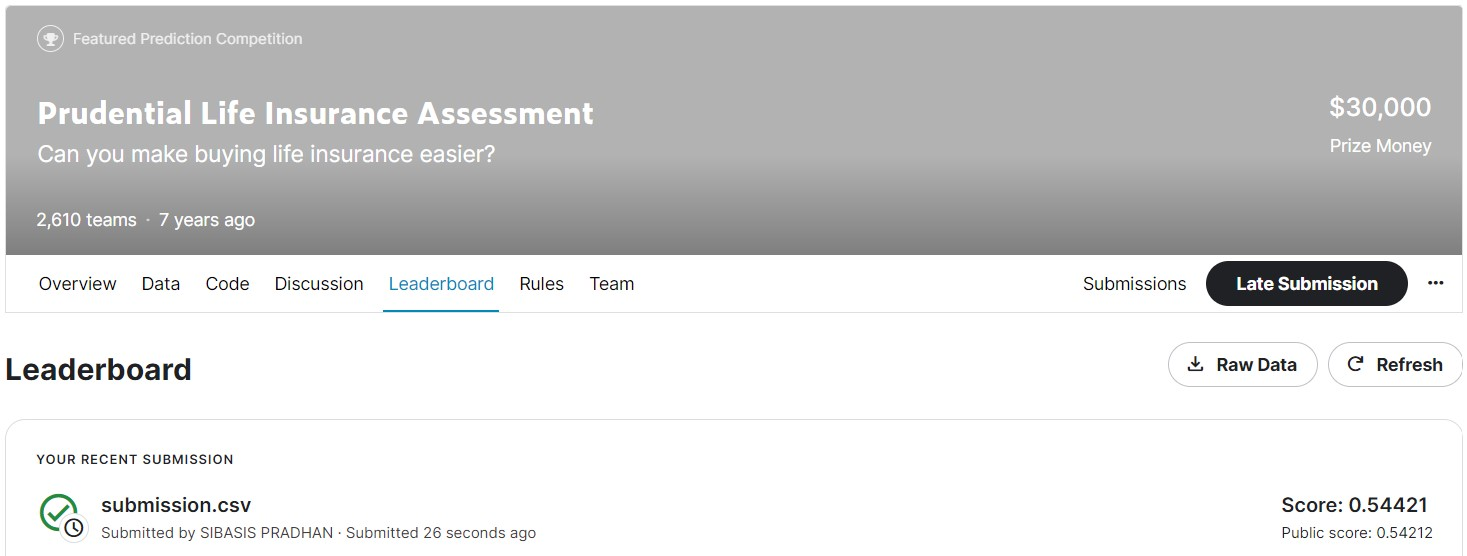

# Saving and Loading Trained Models

We can save the parameters (weights and biases) of our trained model to disk, so that we needn't retrain the model from scratch each time we wish to use it. Along with the model, it's also important to save `imputers, scalers, encoders and even column names`. Anything that will be required while generating predictions using the model should be saved.

We can use the `joblib` module to save and load Python objects on the disk.

In [55]:
import joblib

In [56]:
best_model = {
    'model': xgb_ordinal,    
    'estimators_name': estimators_name,  
    'estimators' : estimators,
    'ensemble_name' : ensemble_name,
    'ensemble_func': ensemble_func,
    'clf': clf,    
    'best_cv_df': best_cv_df,
    'linear_ordinal': linear_ordinal,
    'xgb_ordinal': xgb_ordinal,
    'mlp_ordinal': mlp_ordinal,
    'X_train': X,
    'y_train': y,
    'X_test': X_test
}

In [58]:
joblib.dump(best_model, 'best_model.joblib')

['best_model.joblib']

The object can be loaded back using joblib.load

In [59]:
check_model = joblib.load('best_model.joblib')

In [ ]:
# Run CV 
X = check_model['X_train']
y = check_model['y_train']
X_test = check_model['X_test']
estimators = check_model['estimators']
pred_proba = stack_clf(estimators, X, y,  X_test, n_folds=5, shuffle=True, random_state=config['random_state'])
pred = pred_proba.argmax(axis=1)
pred_trans = pred + 1

res_df = pd.DataFrame({'Id': test['Id'], 'Response': pred_trans})
res_df.to_csv('submission_out.csv', index=False)
print(ensemble_name)

In [60]:
X_test = check_model['X_test']
preds = check_model['model'].predict(X_test)
preds

array([1, 7, 5, ..., 0, 1, 5], dtype=int64)

In [61]:
preds = preds + 1
pd.value_counts(preds)

8    6880
6    3971
7    2789
5    2202
2    1545
1    1071
4     697
3     610
dtype: int64

In [63]:
preds_proba = check_model['model'].predict_proba(X_test)
preds_proba

array([[ 6.7757070e-02,  6.3758385e-01, -6.2822199e-01, ...,
         4.5467323e-01,  5.0509524e-01,  1.2556693e-03],
       [ 3.0116993e-01, -2.5113589e-01,  3.7904859e-01, ...,
         2.1388912e-01,  1.9401047e-01,  4.4376722e-01],
       [ 5.2228689e-02,  3.7141204e-02, -4.6860337e-02, ...,
         4.0953153e-01,  3.7949693e-01,  9.7511187e-02],
       ...,
       [ 5.2257615e-01, -2.3294050e-01,  4.6246254e-01, ...,
         4.6320701e-01,  1.0246862e-01,  3.0335746e-05],
       [ 5.1276684e-02,  9.1801220e-01, -6.7774647e-01, ...,
         2.8361301e-03,  1.9164832e-04,  1.8780400e-05],
       [ 1.9665360e-03,  8.4068298e-02, -6.5268397e-02, ...,
         8.5971761e-01,  8.3114780e-02,  1.6780467e-04]], dtype=float32)

In [64]:
submission_df = pd.read_csv(data_dir + '/sample_submission.csv.zip', index_col='Id')
submission_df.head()

Response
Id          
1          8
3          8
4          8
9          8
12         8

In [65]:
submission_df['Response']  = preds
submission_df

Response
Id             
1             2
3             8
4             6
9             6
12            8
...         ...
79093         8
79099         8
79102         1
79125         2
79129         6

[19765 rows x 1 columns]

In [66]:
submission_df.to_csv('submission_best.csv')

In [67]:
from IPython.display import FileLink
# Doesn't work on Colab, use the file browser instead.
FileLink('submission_best.csv')

D:\PythonCode\Jovian\ZeroToGbms\ml-final-project-prudential-life-insurance\submission_best.csv

Make a submissions to kaggle: https://www.kaggle.com/competitions/prudential-life-insurance-assessment/submissions

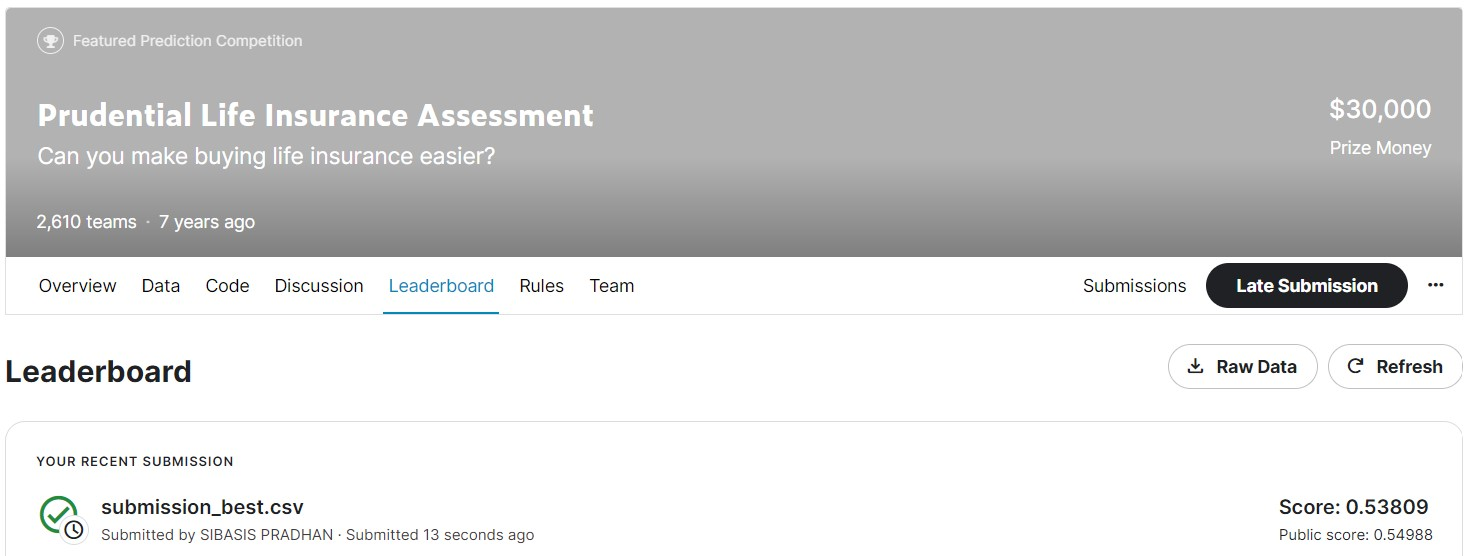

In [68]:
pd.value_counts(submission_df['Response'])

8    6880
6    3971
7    2789
5    2202
2    1545
1    1071
4     697
3     610
Name: Response, dtype: int64

In [ ]:
jovian.commit()

<IPython.core.display.Javascript object>

# Review for areas of improvement

> Whilst this project has aimed to showcase an implementation of the DS/ML workflow in an insurance-based context, it does not aim to provide a comprehensive "A-Z" approach on how to apply ML techniques for the risk classification of insurance applicants. There are, however, a couple of areas where this project could be improved.
>
> For example, in terms of **model performance**:
> * The aim of this project has been to establish an ML model that is capable of accurately predicting risk ratings (split between 8 different categories) for insurance applicants. However, as this involves working with a fairly complex dataset with a wide range of features, the model has not been fully able to capture every single nuance within the dataset, and has instead generalised to predict across the entire distribution to a reasonable degree of accuracy. Therefore, the model may actually prove to be more useful for business purposes if it was instead assigned to predict based on broader sets of risk bandings (e.g. classes 1-3 could be grouped together into Low, classes 4-6 into Medium, and classes 7-9 into High). Then, further refinement of these initial groupings could be made by assembling another layer of classifiers that are specifically trained on datasets that are representative of each risk banding (e.g. another model specifically trained for performing further segmentation of low-risk applicants).
>
> In terms of **feature engineering**:
> * As this dataset's feature names have been anonymised, it has not been possible to incorporate "business logic"-driven feature engineering directly into the model preparation process. However, potential interactions between features could still be studied further during EDA in order to produce new features that take advantage of statistical correlations within the dataset. With the assistance of an "unanonymised" dataset as well as the input of subject matter expertise, it may be possible to create more predictive features and validate them for use in production.
>
> Lastly, in terms of **feature selection**:
> * More stringent and quantitative-based approaches could have been used, in order to combine the methods employed for selecting the list of features that would be supplied to each model during the training process. For clarity, whilst we used Mutual Information/Variance Inflation Factor/Principal Component analysis techniques to display how the importance of each feature varied throughout the dataset, we only relied on Lasso regularisation in order to produce the final cut of selected features. It may be worth considering the use of a "voting system" in order to select features based on how they are ranked across each of the techniques used, so that one technique alone does not provide a final view.

# Acknowledgements

> In addition to the sources cited earlier above, I would also like to thank **Prudential** for publishing the life insurance applicant dataset that was considered in this project.
> 
> Additional information regarding the dataset that was used throughout this project, as well as the affiliated 2016 competition "**Prudential Life Insurance Assessment**" hosted on Kaggle, can be found [here](https://www.kaggle.com/competitions/prudential-life-insurance-assessment/).